Author: Jonathan Gong

In [265]:
import pandas as pd
import os
import sys
import sktime
from sktime.annotation.hmm_learn import GMMHMM 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Data processing

##### Data Loading

In [266]:
# Load one of the CSV files to inspect its columns
sample_file = pd.read_csv('../data/raw/500030_2024-07-01_2024-09-30.csv')


In [267]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}', dtype={'template': 'str'}))

#### Data Processing

In [268]:
def dataprocessing(csv_files):

    # Extract the date, bgl, and msg_type columns from each CSV file
    each_bgl =[]
    for file in csv_files:
        each_df = file[["date", "bgl", "msg_type"]]
        each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
        each_df['date'] = each_df['date'].fillna(method='ffill')
        each_df['bgl'] = each_df['bgl'].fillna(method='ffill')
        each_df["msg_type"] = [
        1 if i == 'INTERVENTION_SNACK' else 2 if i == 'ANNOUNCE_MEAL' else 0
        for i in each_df["msg_type"]
        ]
        each_df = each_df.sort_values('date')
        # each_df.drop_duplicates(subset=['date'], inplace = True)
        # each_df.set_index('date', inplace=True)
        each_bgl.append(each_df)

    # Extract the date, time, and day columns from each df and split them into seperate days
    days_patients = []
    for bgl in each_bgl:
        # (hour:minute:second)
        bgl['time'] = bgl['date'].dt.time
        # (year-month-day)
        bgl['day'] = bgl['date'].dt.date
        # unique days
        unique_days = bgl['day'].unique()
        day_data = []
        for i, day in enumerate(unique_days):
            bgl_day = bgl[bgl['day'] == day]
            day_data.append(bgl_day[["date", "bgl"]])

        days_patients.append(day_data)

    # set index to date
    for patient_days in days_patients:
        for df in patient_days:
            df.set_index('date', inplace=True)

    # Scale BGL data
    patients_scaled = []
    scaler = StandardScaler()
    for patient_days in days_patients:
        scaled_data = scaler.fit_transform(pd.concat(patient_days))
        patients_scaled.append(scaled_data)
    
    # Normalize BGL data
    # patients_normalized = []
    # for patient_days in days_patients:
    #     print(pd.concat(patient_days))
    #     norm_data = pd.concat(patient_days)/max(pd.concat(patient_days))
    #     patients_normalized.append(norm_data)

    # Make ground truth labels for BGL data
    patients_labels = []
    for bgl in each_bgl:
        patients_labels.append(bgl[["date", "msg_type"]])

    # bgl_with_labels = days_patients.loc[:, "msg_type"] = patients_labels


    # return days_patients, patients_scaled, patients_normalized, patients_labels
    return days_patients, patients_scaled, patients_labels

# Model

In [269]:
def runGMMHMM(supervised, X, n_components, n_mix, n_iter, Y = "bruh"):

    # make intial parameters for GMMHMM model
    data_used = X
    n_components = 2 # Number of components in the GMMHMM
    kmeans = KMeans(n_clusters=n_components).fit(data_used)
    initial_means = kmeans.cluster_centers_

    if not supervised:
        model = GMMHMM(n_components=n_components, n_mix=n_mix, n_iter=n_iter, covariance_type = 'full',  verbose = True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        model.fit(X)
        return model
    else:
        model = GMMHMM(n_mix=n_mix, n_iter=n_iter, covariance_type = 'full', verbose=True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        print("supervised")
        model.fit_predict(X = X, Y = Y)
        return model

# Run

In [270]:
days_patients, patients_scaled, patients_labels = dataprocessing(csv_files)

C:\Users\jonat\AppData\Local\Temp\ipykernel_25452\2234620237.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
C:\Users\jonat\AppData\Local\Temp\ipykernel_25452\2234620237.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  each_df['date'] = each_df['date'].fillna(method='ffill')
C:\Users\jonat\AppData\Local\Temp\ipykernel_25452\2234620237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [271]:
all_days_patient_0 = pd.concat(days_patients[0])
all_days_patient_1 = pd.concat(days_patients[1])

In [272]:
n_components = 3
model = runGMMHMM(supervised= False, n_components=n_components, X = all_days_patient_0, n_mix = 2, n_iter = 100)


         1 -206243.59520702             +nan
         2 -179398.78871531  +26844.80649172
         3 -184209.07574088   -4810.28702557
Model is not converging.  Current: -184209.0757408779 is not greater than -179398.78871530507. Delta is -4810.287025572819


In [273]:
from scipy.ndimage import gaussian_filter1d

test_data = all_days_patient_0
test_smoothed = gaussian_filter1d(all_days_patient_0, sigma=15)

hidden_states = model.predict(test_smoothed.reshape(-1, 1))


In [274]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([0])

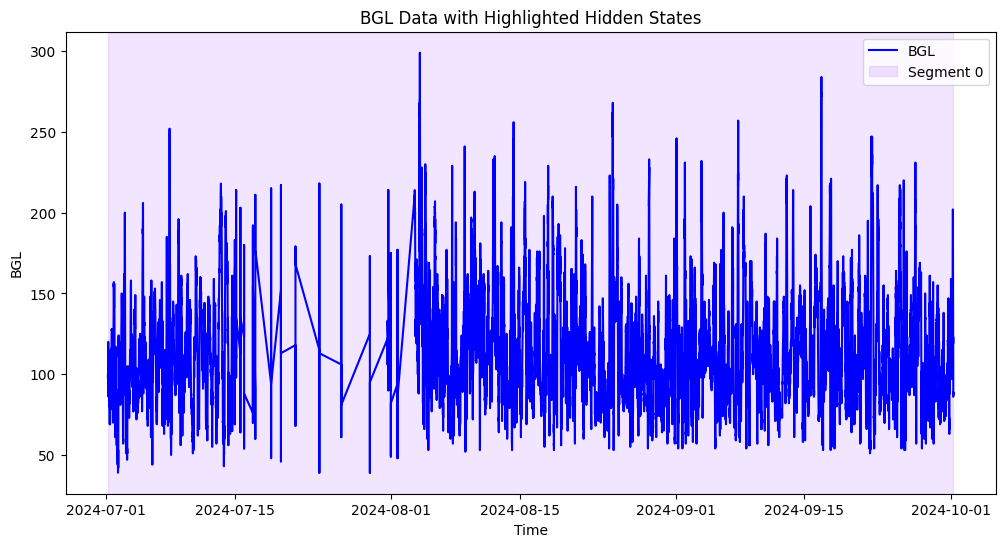

In [275]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Convert numpy array back to DataFrame
bruh = pd.DataFrame(test_smoothed, index=test_data.index, columns=['bgl'])

bruh = all_days_patient_0
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

In [276]:
num_instances = 500

In [277]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse_output=False)
Y_0 = encoder.fit_transform(patients_labels[0][0:num_instances])

In [278]:
n_components = 400
model = runGMMHMM(supervised= True, n_components=n_components, X = all_days_patient_0[0:num_instances], n_mix = 3, n_iter = 100, Y = Y_0)

supervised


         1   -2391.88008915             +nan
         2   -2315.14085489     +76.73923426
         3   -2312.44668440      +2.69417050
         4   -2312.07725700      +0.36942739
         5   -2311.66411399      +0.41314301
         6   -2311.19141892      +0.47269508
         7   -2310.66470384      +0.52671508
         8   -2310.10189271      +0.56281112
         9   -2309.53052492      +0.57136779
        10   -2308.98167710      +0.54884782
        11   -2308.48162005      +0.50005705
        12   -2308.04553339      +0.43608666
        13   -2307.67635803      +0.36917536
        14   -2307.36803119      +0.30832684
        15   -2307.11009037      +0.25794082
        16   -2306.89130325      +0.21878712
        17   -2306.70166323      +0.18964002
        18   -2306.53310035      +0.16856287
        19   -2306.37946241      +0.15363795
        20   -2306.23618398      +0.14327843
        21   -2306.09988534      +0.13629864
        22   -2305.96801531      +0.13187002
        23

In [279]:
hidden_states = model.predict(all_days_patient_0[0:num_instances])

In [280]:
np.unique(hidden_states)

array([0])

In [281]:
# gt_labels_0 = patients_labels[0]["msg_type"][0:num_instances]

In [282]:
gt_labels_0 = patients_labels[0][0:num_instances]

500
[Timestamp('2024-07-01 18:27:41+0000', tz='UTC')]
500
[Timestamp('2024-07-01 09:47:40+0000', tz='UTC')
 Timestamp('2024-07-01 18:07:41+0000', tz='UTC')
 Timestamp('2024-07-01 18:52:42+0000', tz='UTC')
 Timestamp('2024-07-01 22:42:42+0000', tz='UTC')
 Timestamp('2024-07-01 23:52:42+0000', tz='UTC')
 Timestamp('2024-07-02 01:32:42+0000', tz='UTC')
 Timestamp('2024-07-02 02:07:43+0000', tz='UTC')
 Timestamp('2024-07-02 03:42:42+0000', tz='UTC')
 Timestamp('2024-07-02 04:07:42+0000', tz='UTC')
 Timestamp('2024-07-02 07:42:43+0000', tz='UTC')
 Timestamp('2024-07-02 07:47:43+0000', tz='UTC')
 Timestamp('2024-07-02 15:02:44+0000', tz='UTC')
 Timestamp('2024-07-02 16:32:43+0000', tz='UTC')
 Timestamp('2024-07-02 18:22:44+0000', tz='UTC')]


c:\Users\jonat\Documents\Code\WAT.ai\bg_control-1\0_meal_identification\meal_identification\venv\Lib\site-packages\matplotlib\dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

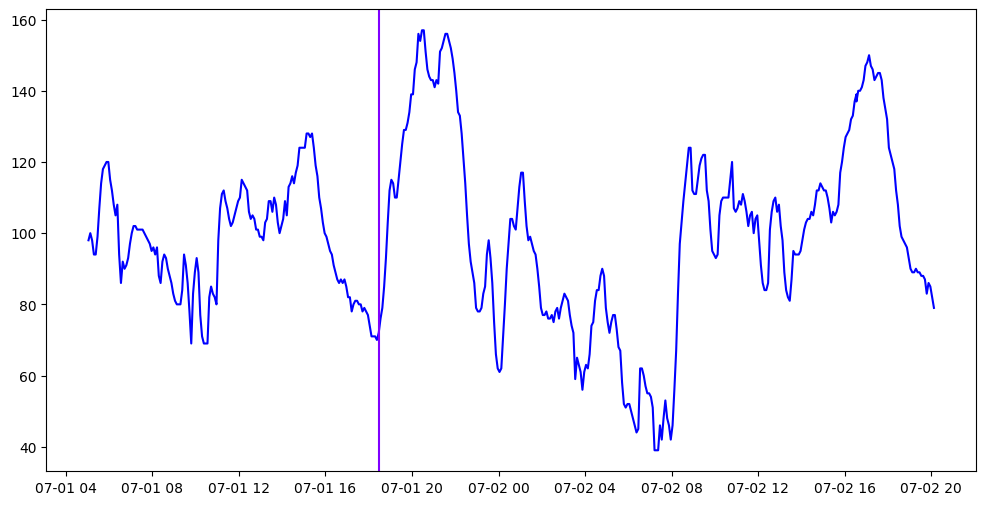

In [294]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))


bruh = all_days_patient_0[0:num_instances]
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
# unique_segments = np.unique(hidden_states)
# colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

# for segment, color in zip(unique_segments, colors):
#     masks = hidden_states == segment
#     print(len(masks))
#     segment_indices = bruh.index[masks] 
#     plt.axvspan(segment_indices.min(), segment_indices.max(),
#                 alpha=0.1, color=color, label=f'Segment {segment}')

unique_labels = [1, 2]
label_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for segment, color in zip(unique_labels, label_colors):
    masks = gt_labels_0["msg_type"] == segment
    print(len(masks))
    segment_indices = gt_labels_0["date"][masks].to_numpy()
    print(segment_indices)
    plt.axvline(segment_indices, color=color, label=f'Segment {segment}')
# masks = gt_labels_0 == 1
# gt_labels_0[masks]
# plt.plot(bruh.index, gt_labels_0[gt_labels_0 == 1], label='gt', color='red')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

## Proof that the model doesn't work

This is the example from the sktime documentation for GMMHMM

In [ ]:
from sktime.annotation.hmm_learn import GMMHMM 
from sktime.annotation.datagen import piecewise_normal
data = piecewise_normal( 
   means=[2, 4, 1], lengths=[10, 35, 40], random_state=7
   ).reshape((-1, 1))
model = GMMHMM(n_components=3) 
model = model.fit(data) 
labeled_data = model.predict(data)


Model is not converging.  Current: -162.74612464500595 is not greater than -153.44005727436024. Delta is -9.306067370645707


In [289]:
np.unique(labeled_data)

array([2])

Using both unsupervised and supervised methods with many preprocessing techniques such as normalization, scaling, smoothing, and further hyperparameter tuning of the model did not produce any results. Thus the GMMHMM is not recommended for our use